<a href="https://colab.research.google.com/github/politecat314/car-damage-detection-peltarion/blob/master/Peltarion_with_data_augmentation_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

# **Loading the dataset**

In [2]:
batch_size = 32
img_height = 224
img_width = 224

## Mount Google drive

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
labels_path = "gdrive/MyDrive/peltarion dataset/preprocessed/index.csv"
labels = pd.read_csv(labels_path)

## One hot encoding y values

In [8]:
label_names = labels['class'].unique()
print(label_names)

y = np.zeros((len(labels), len(label_names)), dtype=int)

for index, name in enumerate(labels['class']):
    y[index][np.where(label_names==name)] = 1

print(y[:5]) # check if working correctly
y = y.tolist()

['unknown' 'head_lamp' 'door_scratch' 'glass_shatter' 'tail_lamp'
 'bumper_dent' 'door_dent' 'bumper_scratch']
[[1 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0]
 [0 1 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0]]


In [11]:
## Trying value vector to see if y values work
y = np.argmax(y, axis=1)
y = y.tolist()
y[:5]

[0, 1, 2, 1, 0]

## Create train and validation dataset

In [12]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    'gdrive/MyDrive/peltarion dataset/preprocessed', labels=y, label_mode='categorical', color_mode='rgb', 
    batch_size=32, image_size=(224, 224), seed=42, 
    validation_split=0.2, subset='training'
)


val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    'gdrive/MyDrive/peltarion dataset/preprocessed', labels=y, label_mode='categorical', color_mode='rgb', 
    batch_size=32, image_size=(224, 224), seed=42, 
    validation_split=0.2, subset='validation'
)

Found 1512 files belonging to 1 classes.
Using 1210 files for training.
Found 1512 files belonging to 1 classes.
Using 302 files for validation.


## Size of the datasets

In [7]:
for image_batch, labels_batch in train_dataset:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32, 8, 1)


## Visualize the dataset

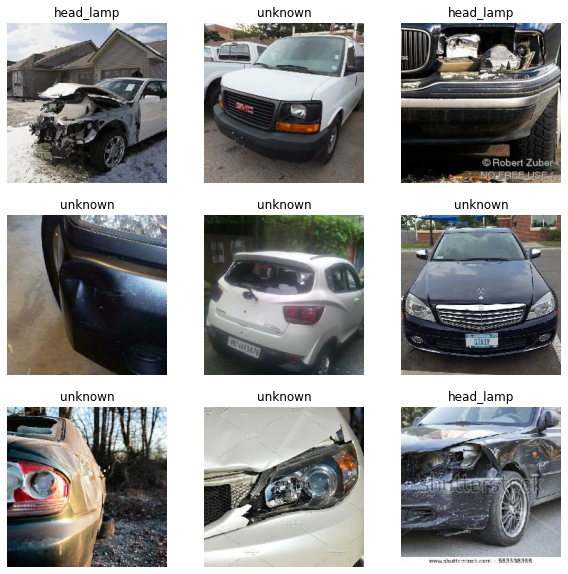

In [8]:
# plt.figure(figsize=(10, 10))
# for images, labels in train_dataset.take(1):
#   for i in range(9):
#     ax = plt.subplot(3, 3, i + 1)
#     plt.imshow(images[i].numpy().astype("uint8"))
#     plt.title(label_names[np.argmax(labels[i])])
#     plt.axis("off")

## Configure dataset for performance

In [13]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.cache().prefetch(buffer_size=AUTOTUNE)

# **Model definition**

## Data augmentation

In [14]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

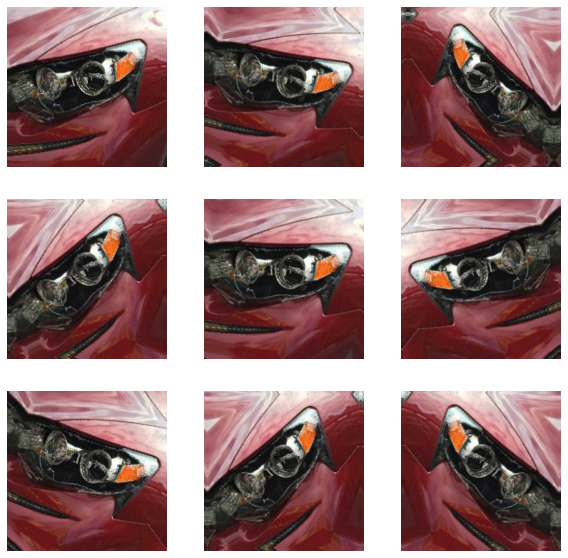

In [15]:
# plt.figure(figsize=(10, 10))
# for images, _ in train_dataset.take(1):
#   for i in range(9):
#     augmented_images = data_augmentation(images)
#     ax = plt.subplot(3, 3, i + 1)
#     plt.imshow(augmented_images[0].numpy().astype("uint8"))
#     plt.axis("off")

## Model architecture

In [22]:
num_classes = len(label_names)

model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  # layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [23]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
rescaling_1 (Rescaling)      (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 224, 224, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 112, 112, 32)      4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 56, 56, 64)       

## Compile and train

In [24]:
epochs = 15
history = model.fit(
  train_dataset,
  validation_data=val_dataset,
  epochs=epochs
)

Epoch 1/15
38/38 [==============================] - 63s 2s/step - loss: 0.8063 - accuracy: 0.6132 - val_loss: 0.6818 - val_accuracy: 0.6291
Epoch 2/15
38/38 [==============================] - 62s 2s/step - loss: 0.6677 - accuracy: 0.6240 - val_loss: 0.6628 - val_accuracy: 0.6192
Epoch 3/15
38/38 [==============================] - 62s 2s/step - loss: 0.6694 - accuracy: 0.6132 - val_loss: 0.6672 - val_accuracy: 0.6291
Epoch 4/15
38/38 [==============================] - 62s 2s/step - loss: 0.6670 - accuracy: 0.6099 - val_loss: 0.6614 - val_accuracy: 0.6291
Epoch 5/15
38/38 [==============================] - 62s 2s/step - loss: 0.6594 - accuracy: 0.6248 - val_loss: 0.6883 - val_accuracy: 0.6258
Epoch 6/15
38/38 [==============================] - 62s 2s/step - loss: 0.6618 - accuracy: 0.6248 - val_loss: 0.6683 - val_accuracy: 0.6291
Epoch 7/15
38/38 [==============================] - 62s 2s/step - loss: 0.6681 - accuracy: 0.6231 - val_loss: 0.6593 - val_accuracy: 0.6258
Epoch 8/15
38/38 [==

## Visualize training results

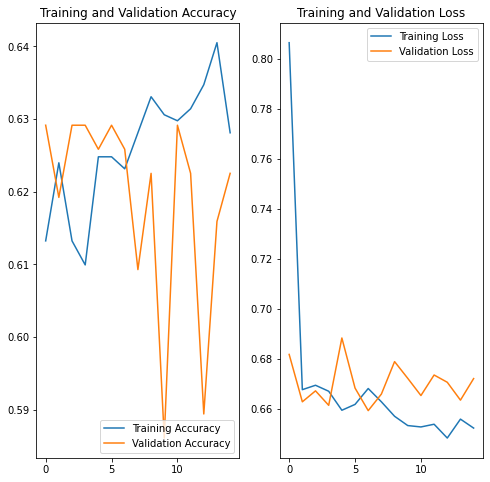

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()